In [1]:
import pandas as pd
import numpy as np
import urllib
import operator
from sklearn import preprocessing
from beautifultable import BeautifulTable
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings("ignore")

In [2]:
def getConfusionMatrix(predictedClass, actualClass):
    trueNegative = 0
    truePositive = 0
    falseNegative = 0
    falsePositive = 0
    for i in range(0, len(predictedClass)):
        if predictedClass[i]=='M':
            if actualClass[i]=='M':
                trueNegative += 1
            else:
                falseNegative += 1
        else:
            if actualClass[i]=='M':
                falsePositive += 1
            else:
                truePositive += 1
    return trueNegative, truePositive, falseNegative, falsePositive

In [3]:
def printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive):
    tableData = []
    row1 = []
    row1.append('')
    row1.append('Predicted Benign')
    row1.append('Predicted Malignant')
    tableData.append(row1)
    
    row2 = []
    row2.append('Actual Benign')
    row2.append(truePositive)
    row2.append(falseNegative)
    tableData.append(row2)
    
    row3 = []
    row3.append('Actual Malignant')
    row3.append(falsePositive)
    row3.append(trueNegative)
    tableData.append(row3)
    
    printDatainTable([], tableData)

In [4]:
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(max_width=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [5]:
def getClusterLabel(firstMCnt, firstBCnt, secondMCnt, secondBCnt):
    firstLabel = ''
    secondLabel = ''
    if firstMCnt>firstBCnt:
        firstLabel = 'M'
    elif firstBCnt>firstMCnt:
        firstLabel = 'B'
        
    if secondMCnt>secondBCnt:
        secondLabel = 'M'
    elif secondBCnt>secondMCnt:
        secondLabel = 'B'
        
    if firstLabel=='' and secondLabel!='':
        if secondLabel == 'M':
            firstLabel = 'B'
        else:
            firstLabel = 'M'
    elif firstLabel!='' and secondLabel=='':
        if firstLabel=='M':
            secondLabel = 'B'
        else:
            secondLabel = 'M'
    else:
        if firstBCnt>secondBCnt:
            firstLabel = 'B'
            secondLabel = 'M'
        else:
            firstLabel = 'M'
            secondLabel = 'B'
    return firstLabel, secondLabel

In [6]:
def getClusterCentroids(clusterLabels, data):
    centroids = np.zeros((2, data.shape[1]))
    sampleCnt = np.zeros(2)
    for i in range(0, len(clusterLabels)):
        label = clusterLabels[i]
        sampleCnt[label] += 1
        centroids[label] += data[i:i+1]
    for i in range(0, 2):
        if sampleCnt[i]!=0:
            centroids[i] /= sampleCnt[i]
    return centroids

In [7]:
dataURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Supervised-Semi-supervised-and-Unsupervised-Learning/master/wdbc.data'
featuresURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Supervised-Semi-supervised-and-Unsupervised-Learning/master/features.txt'
simulatedM = 30
testSize = 0.2

In [8]:
features = []
featuresData = urllib.request.urlopen(featuresURL)
for line in featuresData:
    line = line.decode('utf-8')
    line = line.replace('\n', '')
    line = line.strip()
    features.append(line)
    
columnNames = []
columnNames.append('ID')
columnNames.append('Class')
for feature in features:
    columnNames.append(feature)

# Read data and split data into training and testing set.

In [9]:
data = pd.read_csv(dataURL, names=columnNames)
print('----------------------------------------------------------------------')
print('Total Observations:', data.shape[0])
print('First 5 observations:')
print('----------------------------------------------------------------------')
print(data.head())

----------------------------------------------------------------------
Total Observations: 569
First 5 observations:
----------------------------------------------------------------------
         ID Class  mean_radius  mean_texture  mean_perimeter  mean_area  \
0    842302     M        17.99         10.38          122.80     1001.0   
1    842517     M        20.57         17.77          132.90     1326.0   
2  84300903     M        19.69         21.25          130.00     1203.0   
3  84348301     M        11.42         20.38           77.58      386.1   
4  84358402     M        20.29         14.34          135.10     1297.0   

   mean_smoothness  mean_compactness  mean_concavity  mean_concave points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414 

In [10]:
minMaxScaler = preprocessing.MinMaxScaler()
normalizedData = minMaxScaler.fit_transform(data[features])
normalizedData = pd.DataFrame(normalizedData, columns=features)
normalizedData = pd.concat([normalizedData, data['Class']], axis=1)

In [11]:
malignData = pd.DataFrame()
benignData = pd.DataFrame()
cnt = 0
for i in range(0, len(normalizedData)):
    if data['Class'][i]=='M':
        malignData = pd.concat([malignData, data[i:i+1]])
    elif data['Class'][i]=='B':
        benignData = pd.concat([benignData, data[i:i+1]])
        
totalMalignCnt = malignData.shape[0]
totalBenignCnt = benignData.shape[0]
print('Total Malign Data:', totalMalignCnt)
print('Total Benign Data:', totalBenignCnt)

Total Malign Data: 212
Total Benign Data: 357


In [12]:
testMalignCnt = 43
testBenignCnt = 72

In [13]:
testMalign = malignData[0:testMalignCnt]
trainMalign = malignData[testMalignCnt:]

In [14]:
print('----------------------------------------------------------------------')
print('Total Train Malign Observations:', trainMalign.shape[0])
print('First 5 training observations of class Malign:')
print('----------------------------------------------------------------------')
print(trainMalign.head())

----------------------------------------------------------------------
Total Train Malign Observations: 169
First 5 training observations of class Malign:
----------------------------------------------------------------------
        ID Class  mean_radius  mean_texture  mean_perimeter  mean_area  \
53  857392     M        18.22         18.70          120.30     1033.0   
54  857438     M        15.10         22.02           97.26      712.8   
56  857637     M        19.21         18.57          125.50     1152.0   
57  857793     M        14.71         21.59           95.55      656.9   
62  858986     M        14.25         22.15           96.42      645.7   

    mean_smoothness  mean_compactness  mean_concavity  mean_concave points  \
53          0.11480           0.14850         0.17720              0.10600   
54          0.09056           0.07081         0.05253              0.03334   
56          0.10530           0.12670         0.13230              0.08994   
57          0.113

In [15]:
print('----------------------------------------------------------------------')
print('Total Test Malign Observations:', testMalign.shape[0])
print('First 5 testing observations of class Malign:')
print('----------------------------------------------------------------------')
print(testMalign.head())

----------------------------------------------------------------------
Total Test Malign Observations: 43
First 5 testing observations of class Malign:
----------------------------------------------------------------------
         ID Class  mean_radius  mean_texture  mean_perimeter  mean_area  \
0    842302     M        17.99         10.38          122.80     1001.0   
1    842517     M        20.57         17.77          132.90     1326.0   
2  84300903     M        19.69         21.25          130.00     1203.0   
3  84348301     M        11.42         20.38           77.58      386.1   
4  84358402     M        20.29         14.34          135.10     1297.0   

   mean_smoothness  mean_compactness  mean_concavity  mean_concave points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250

In [16]:
testBenign = benignData[0:testBenignCnt]
trainBenign = benignData[testBenignCnt:]

In [17]:
print('----------------------------------------------------------------------')
print('Total Train Benign Observations:', trainBenign.shape[0])
print('First 5 training observations of class Benign:')
print('----------------------------------------------------------------------')
print(trainBenign.head())

----------------------------------------------------------------------
Total Train Benign Observations: 285
First 5 training observations of class Benign:
----------------------------------------------------------------------
          ID Class  mean_radius  mean_texture  mean_perimeter  mean_area  \
155  8711003     B        12.25         17.94           78.27      460.3   
157  8711216     B        16.84         19.46          108.40      880.2   
158   871122     B        12.06         12.74           76.84      448.6   
159   871149     B        10.90         12.96           68.69      366.8   
160  8711561     B        11.75         20.18           76.10      419.8   

     mean_smoothness  mean_compactness  mean_concavity  mean_concave points  \
155          0.08654           0.06679         0.03885             0.023310   
157          0.07445           0.07223         0.05150             0.027710   
158          0.09311           0.05241         0.01972             0.019630   
1

In [18]:
print('----------------------------------------------------------------------')
print('Total Test Benign Observations:', testBenign.shape[0])
print('First 5 testing observations of class Benign:')
print('----------------------------------------------------------------------')
print(testBenign.head())

----------------------------------------------------------------------
Total Test Benign Observations: 72
First 5 testing observations of class Benign:
----------------------------------------------------------------------
          ID Class  mean_radius  mean_texture  mean_perimeter  mean_area  \
19   8510426     B       13.540         14.36           87.46      566.3   
20   8510653     B       13.080         15.71           85.63      520.0   
21   8510824     B        9.504         12.44           60.34      273.9   
37    854941     B       13.030         18.42           82.61      523.8   
46  85713702     B        8.196         16.84           51.71      201.9   

    mean_smoothness  mean_compactness  mean_concavity  mean_concave points  \
19          0.09779           0.08129         0.06664             0.047810   
20          0.10750           0.12700         0.04568             0.031100   
21          0.10240           0.06492         0.02956             0.020760   
37      

# Supervised Learning L1-Penalized SVM

In [19]:
supAvgTrainAccuracy = 0.0
supAvgTestAccuracy = 0.0
supAvgTrainPrecision = 0.0
supAvgTestPrecision = 0.0
supAvgTrainRecall = 0.0
supAvgTestRecall = 0.0
supAvgTrainFScore = 0.0
supAvgTestFScore = 0.0
supAvgTrainAUC = 0.0
supAvgTestAUC = 0.0
for m in range(0, simulatedM):
    trainMalignData, testMalignData = train_test_split(malignData, test_size=0.2, shuffle=True)
    trainBenignData, testBenignData = train_test_split(benignData, test_size=0.2, shuffle=True)
    
    trainMData = pd.concat([trainMalignData, trainBenignData])
    testMData = pd.concat([testMalignData, testBenignData])
    
    CRange = np.logspace(-1, 4, 20)
    l1SVMModel = LinearSVC(penalty='l1', dual=False)
    l1Parameters = {'C':CRange}
    l1GridModel = GridSearchCV(l1SVMModel, l1Parameters, cv=KFold(5))
    l1GridModel = l1GridModel.fit(trainMData[features], trainMData['Class'])
    
    predictedTrainClass = l1GridModel.predict(trainMData[features])
    predictedTestClass = l1GridModel.predict(testMData[features])
    
    trainAccuracy = accuracy_score(predictedTrainClass, np.array(trainMData['Class']))
    trainAccuracy = round(trainAccuracy, 3)
    
    testAccuracy = accuracy_score(predictedTestClass, np.array(testMData['Class']))
    testAccuracy = round(testAccuracy, 3)
    
    trainTN, trainTP, trainFN, trainFP = getConfusionMatrix(predictedTrainClass, np.array(trainMData['Class']))
    testTN, testTP, testFN, testFP = getConfusionMatrix(predictedTestClass, np.array(testMData['Class']))
    
    trainPrecision = trainTP/(trainTP+trainFP)
    trainPrecision = round(trainPrecision, 3)
    
    testPrecision = testTP/(testTP+testFP)
    testPrecision = round(testPrecision, 3)
    
    trainRecall = trainTP/(trainTP+trainFN)
    trainRecall = round(trainRecall, 3)
    
    testRecall = testTP/(testTP+testFN)
    testRecall = round(testRecall, 3)
    
    trainFScore = (2*trainPrecision*trainRecall)/(trainPrecision+trainRecall)
    trainFScore = round(trainFScore, 3)
    
    testFScore = (2*testPrecision*testRecall)/(testPrecision+testRecall)
    testFScore = round(testFScore, 3)
    
    supAvgTrainAccuracy += trainAccuracy
    supAvgTestAccuracy += testAccuracy
    
    supAvgTrainPrecision += trainPrecision
    supAvgTestPrecision += testPrecision
    
    supAvgTrainRecall += trainRecall
    supAvgTestRecall += testRecall
    
    supAvgTrainFScore += trainFScore
    supAvgTestFScore += testFScore
    
    actualTrainClass = np.array(trainMData['Class'])
    actualTestClass = np.array(testMData['Class'])
    
    predTrainClassProb = l1GridModel.decision_function(trainMData[features])
    predTestClassProb = l1GridModel.decision_function(testMData[features])
    
    for i in range(0, len(predTrainClassProb)):
        predTrainClassProb[i] = -1*predTrainClassProb[i]
    for i in range(0, len(predTestClassProb)):
        predTestClassProb[i] = -1*predTestClassProb[i]
        
    trainFPR, trainTPR, trainThreshold = roc_curve(actualTrainClass, predTrainClassProb, pos_label='B')
    testFPR, testTPR, testThreshold = roc_curve(actualTestClass, predTestClassProb, pos_label='B')
    
    trainAUC = auc(trainFPR, trainTPR)
    trainAUC = round(trainAUC, 3)
    supAvgTrainAUC += trainAUC
    
    testAUC = auc(testFPR, testTPR)
    testAUC = round(testAUC, 3)
    supAvgTestAUC += testAUC
    
supAvgTrainAccuracy /= simulatedM
supAvgTrainAccuracy = round(supAvgTrainAccuracy, 3)

supAvgTestAccuracy /= simulatedM
supAvgTestAccuracy = round(supAvgTestAccuracy, 3)

supAvgTrainPrecision /= simulatedM
supAvgTrainPrecision = round(supAvgTrainPrecision, 3)

supAvgTestPrecision /= simulatedM
supAvgTestPrecision = round(supAvgTestPrecision, 3)

supAvgTrainRecall /= simulatedM
supAvgTrainRecall = round(supAvgTrainRecall, 3)

supAvgTestRecall /= simulatedM
supAvgTestRecall = round(supAvgTestRecall, 3)

supAvgTrainFScore /= simulatedM
supAvgTrainFScore = round(supAvgTrainFScore, 3)

supAvgTestFScore /= simulatedM
supAvgTestFScore = round(supAvgTestFScore, 3)

supAvgTrainAUC /= simulatedM
supAvgTrainAUC = round(supAvgTrainAUC, 3)

supAvgTestAUC /= simulatedM
supAvgTestAUC = round(supAvgTestAUC, 3)

TRAIN DATA EVALUATION
---------------------------------------------
Average Train Accuracy: 0.987
Average Train Precision: 0.986
Average Train Recall: 0.994
Average Train F-Score: 0.99
Average Train AUC: 0.999


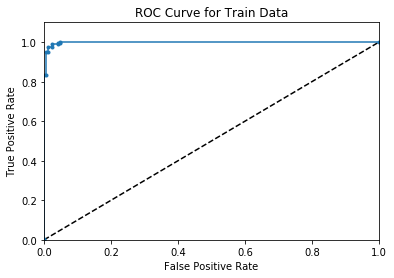

Confusion Matrix for Train Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |       283        |          2          |
+------------------+------------------+---------------------+
| Actual Malignant |        7         |         162         |
+------------------+------------------+---------------------+


In [20]:
print('TRAIN DATA EVALUATION')
print('---------------------------------------------')
print('Average Train Accuracy:', supAvgTrainAccuracy)
print('Average Train Precision:', supAvgTrainPrecision)
print('Average Train Recall:', supAvgTrainRecall)
print('Average Train F-Score:', supAvgTrainFScore)
print('Average Train AUC:', supAvgTrainAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(trainFPR, trainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Train Data:')
printConfusionMatrix(trainTN, trainFP, trainFN, trainTP)

TEST DATA EVALUATION
---------------------------------------------
Average Test Accuracy: 0.965
Average Test Precision: 0.969
Average Test Recall: 0.976
Average Test F-Score: 0.972
Average Test AUC: 0.994


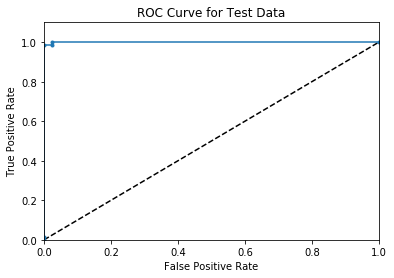

Confusion Matrix for Test Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |        71        |          1          |
+------------------+------------------+---------------------+
| Actual Malignant |        0         |         43          |
+------------------+------------------+---------------------+


In [21]:
print('TEST DATA EVALUATION')
print('---------------------------------------------')
print('Average Test Accuracy:', supAvgTestAccuracy)
print('Average Test Precision:', supAvgTestPrecision)
print('Average Test Recall:', supAvgTestRecall)
print('Average Test F-Score:', supAvgTestFScore)
print('Average Test AUC:', supAvgTestAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(testFPR, testTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Test Data:')
printConfusionMatrix(testTN, testFP, testFN, testTP)

# Semi-Supervised Learning L1-Penalized SVM

In [22]:
semiAvgTrainAccuracy = 0.0
semiAvgTestAccuracy = 0.0
semiAvgTrainPrecision = 0.0
semiAvgTestPrecision = 0.0
semiAvgTrainRecall = 0.0
semiAvgTestRecall = 0.0
semiAvgTrainFScore = 0.0
semiAvgTestFScore = 0.0
semiAvgTrainAUC = 0.0
semiAvgTestAUC = 0.0
for m in range(0, simulatedM):
    trainMalignData, testMalignData = train_test_split(malignData, test_size=0.2, shuffle=True)
    trainBenignData, testBenignData = train_test_split(benignData, test_size=0.2, shuffle=True)
    
    trainMData = pd.concat([trainMalignData, trainBenignData])
    testMData = pd.concat([testMalignData, testBenignData])
    
    labeledMalignData, unlabeledMalignData = train_test_split(trainMalignData, train_size=0.5)
    labeledBenignData, unlabeledBenignData = train_test_split(trainBenignData, train_size=0.5)
    
    labeledTrainData = pd.concat([labeledMalignData, labeledBenignData]) 
    labeledTrainData = labeledTrainData.drop(['ID'], axis=1)
    unlabeledTrainData = pd.concat([unlabeledMalignData, unlabeledBenignData]) 
    unlabeledTrainData = unlabeledTrainData.drop(['ID'], axis=1)
    
    # 1.b(ii)(A)
    CRange = np.logspace(-1, 4, 20)
    l1SVMModel = LinearSVC(penalty='l1', dual=False)
    l1Parameters = {'C':CRange}
    l1GridModel = GridSearchCV(l1SVMModel, l1Parameters, cv=KFold(5))
    l1GridModel = l1GridModel.fit(labeledTrainData[features], labeledTrainData['Class'])
    
    # 1.b(ii)(B)
    while len(unlabeledTrainData)!=0:
        unlabledDistances = l1GridModel.decision_function(unlabeledTrainData[features])
        unlabledDistancesDict = {}
        t = 0
        for idx in unlabeledTrainData.index:
            unlabledDistancesDict[idx] = round(abs(unlabledDistances[t]), 3)
            t += 1
        unlabledDistancesSorted = sorted(unlabledDistancesDict.items(), key=operator.itemgetter(1), reverse=True)
        farthestDataPointIdx = unlabledDistancesSorted[0][0]
        predictedLabel = l1GridModel.predict([unlabeledTrainData.loc[farthestDataPointIdx][features]])
        predictedClassDF = pd.DataFrame(predictedLabel, columns=['Class'])
        predictedClassDF.set_index(pd.Series([farthestDataPointIdx]), inplace=True)
        featureData = pd.DataFrame([unlabeledTrainData.loc[farthestDataPointIdx][features]])
        newLabeledData = pd.merge(featureData, predictedClassDF, left_index=True, right_index=True)

        labeledTrainData = pd.concat([labeledTrainData, newLabeledData])
        unlabeledTrainData = unlabeledTrainData.drop(index=farthestDataPointIdx)

        l1GridModel = l1GridModel.fit(labeledTrainData[features], labeledTrainData['Class'])
        
    predictedTrainClass = l1GridModel.predict(trainMData[features])
    predictedTestClass = l1GridModel.predict(testMData[features])
    
    trainAccuracy = accuracy_score(predictedTrainClass, np.array(trainMData['Class']))
    trainAccuracy = round(trainAccuracy, 3)
    
    testAccuracy = accuracy_score(predictedTestClass, np.array(testMData['Class']))
    testAccuracy = round(testAccuracy, 3)
    
    trainTN, trainTP, trainFN, trainFP = getConfusionMatrix(predictedTrainClass, np.array(trainMData['Class']))
    testTN, testTP, testFN, testFP = getConfusionMatrix(predictedTestClass, np.array(testMData['Class']))
    
    trainPrecision = trainTP/(trainTP+trainFP)
    trainPrecision = round(trainPrecision, 3)
    
    testPrecision = testTP/(testTP+testFP)
    testPrecision = round(testPrecision, 3)
    
    trainRecall = trainTP/(trainTP+trainFN)
    trainRecall = round(trainRecall, 3)
    
    testRecall = testTP/(testTP+testFN)
    testRecall = round(testRecall, 3)
    
    trainFScore = (2*trainPrecision*trainRecall)/(trainPrecision+trainRecall)
    trainFScore = round(trainFScore, 3)
    
    testFScore = (2*testPrecision*testRecall)/(testPrecision+testRecall)
    testFScore = round(testFScore, 3)
    
    semiAvgTrainAccuracy += trainAccuracy
    semiAvgTestAccuracy += testAccuracy
    
    semiAvgTrainPrecision += trainPrecision
    semiAvgTestPrecision += testPrecision
    
    semiAvgTrainRecall += trainRecall
    semiAvgTestRecall += testRecall
    
    semiAvgTrainFScore += trainFScore
    semiAvgTestFScore += testFScore
    
    actualTrainClass = np.array(trainMData['Class'])
    actualTestClass = np.array(testMData['Class'])
    
    predTrainClassProb = l1GridModel.decision_function(trainMData[features])
    predTestClassProb = l1GridModel.decision_function(testMData[features])
    
    for i in range(0, len(predTrainClassProb)):
        predTrainClassProb[i] = -1*predTrainClassProb[i]
    for i in range(0, len(predTestClassProb)):
        predTestClassProb[i] = -1*predTestClassProb[i]
    
    trainFPR, trainTPR, trainThreshold = roc_curve(actualTrainClass, predTrainClassProb, pos_label='B')
    testFPR, testTPR, testThreshold = roc_curve(actualTestClass, predTestClassProb, pos_label='B')
    
    trainAUC = auc(trainFPR, trainTPR)
    trainAUC = round(trainAUC, 3)
    semiAvgTrainAUC += trainAUC
    
    testAUC = auc(testFPR, testTPR)
    testAUC = round(testAUC, 3)
    semiAvgTestAUC += testAUC
    
semiAvgTrainAccuracy /= simulatedM
semiAvgTrainAccuracy = round(semiAvgTrainAccuracy, 3)

semiAvgTestAccuracy /= simulatedM
semiAvgTestAccuracy = round(semiAvgTestAccuracy, 3)

semiAvgTrainPrecision /= simulatedM
semiAvgTrainPrecision = round(semiAvgTrainPrecision, 3)

semiAvgTestPrecision /= simulatedM
semiAvgTestPrecision = round(semiAvgTestPrecision, 3)

semiAvgTrainRecall /= simulatedM
semiAvgTrainRecall = round(semiAvgTrainRecall, 3)

semiAvgTestRecall /= simulatedM
semiAvgTestRecall = round(semiAvgTestRecall, 3)

semiAvgTrainFScore /= simulatedM
semiAvgTrainFScore = round(semiAvgTrainFScore, 3)

semiAvgTestFScore /= simulatedM
semiAvgTestFScore = round(semiAvgTestFScore, 3)

semiAvgTrainAUC /= simulatedM
semiAvgTrainAUC = round(semiAvgTrainAUC, 3)

semiAvgTestAUC /= simulatedM
semiAvgTestAUC = round(semiAvgTestAUC, 3)

TRAIN DATA EVALUATION
---------------------------------------------
Average Train Accuracy: 0.977
Average Train Precision: 0.977
Average Train Recall: 0.986
Average Train F-Score: 0.982
Average Train AUC: 0.993


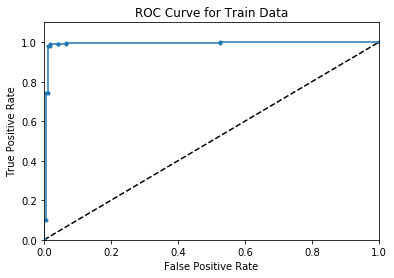

Confusion Matrix for Train Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |       282        |          3          |
+------------------+------------------+---------------------+
| Actual Malignant |        3         |         166         |
+------------------+------------------+---------------------+


In [23]:
print('TRAIN DATA EVALUATION')
print('---------------------------------------------')
print('Average Train Accuracy:', semiAvgTrainAccuracy)
print('Average Train Precision:', semiAvgTrainPrecision)
print('Average Train Recall:', semiAvgTrainRecall)
print('Average Train F-Score:', semiAvgTrainFScore)
print('Average Train AUC:', semiAvgTrainAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(trainFPR, trainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Train Data:')
printConfusionMatrix(trainTN, trainFP, trainFN, trainTP)

TEST DATA EVALUATION
---------------------------------------------
Average Test Accuracy: 0.958
Average Test Precision: 0.964
Average Test Recall: 0.97
Average Test F-Score: 0.967
Average Test AUC: 0.987


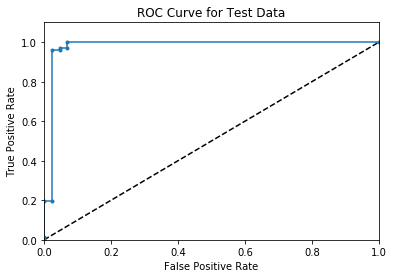

Confusion Matrix for Test Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |        71        |          1          |
+------------------+------------------+---------------------+
| Actual Malignant |        3         |         40          |
+------------------+------------------+---------------------+


In [24]:
print('TEST DATA EVALUATION')
print('---------------------------------------------')
print('Average Test Accuracy:', semiAvgTestAccuracy)
print('Average Test Precision:', semiAvgTestPrecision)
print('Average Test Recall:', semiAvgTestRecall)
print('Average Test F-Score:', semiAvgTestFScore)
print('Average Test AUC:', semiAvgTestAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(testFPR, testTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Test Data:')
printConfusionMatrix(testTN, testFP, testFN, testTP)

# Unsupervised Learning

In [25]:
clusterMCentroids = {}
clusterTestMData = {}
clusterMLabels = {}
clusterAvgTrainAccuracy = 0.0
clusterAvgTrainPrecision = 0.0
clusterAvgTrainRecall = 0.0
clusterAvgTrainFScore = 0.0
clusterAvgTrainAUC = 0.0
clusterAvgTestAccuracy = 0.0
clusterAvgTestPrecision = 0.0
clusterAvgTestRecall = 0.0
clusterAvgTestFScore = 0.0
clusterAvgTestAUC = 0.0

# How do you make sure that the algorithm was not trapped in a local minimum?

K-Means clustering algorithm finds an optimal solution that could be either local best solution or global best solution. To make sure that the algorithm does not get trapped in local minimum is to repeat the clustering algorithm multiple times and take the most optimal solution. In K-means algorithm, every different choice of initial cluster seeds may lead to different clusters because the algorithm tries to optimize the cost function. Therefore, it is better to take a stochastic approach and run the algorithm many times with different initial cluster seeds. This will lead to mulitple clustering results, so choose those clusters that give the lowest error.

# Unsupervised Learning Evaluation for Train Data.

In [26]:
for m in range(0, simulatedM):
    trainMalignData, testMalignData = train_test_split(malignData, test_size=0.2, shuffle=True)
    trainBenignData, testBenignData = train_test_split(benignData, test_size=0.2, shuffle=True)
    
    trainMData = pd.concat([trainMalignData, trainBenignData])
    trainMData = trainMData.reset_index()
    testMData = pd.concat([testMalignData, testBenignData])
    testMData = testMData.reset_index()
    clusterTestMData[m] = testMData
    
    kMeansModel = KMeans(n_clusters=2, init='random')
    kMeansModel = kMeansModel.fit(trainMData[features])
    
    clusterCenters = kMeansModel.cluster_centers_
    clusterMCentroids[m] = clusterCenters
    
    clusterSampleDistances = euclidean_distances(trainMData[features], clusterCenters)

    firstCluster = {}
    secondCluster = {}
    for i in range(0, len(trainMData)):
        firstCluster[i] = clusterSampleDistances[i][0]
        secondCluster[i] = clusterSampleDistances[i][1]
    firstClusterSorted = sorted(firstCluster.items(), key=operator.itemgetter(1))
    secondClusterSorted = sorted(secondCluster.items(), key=operator.itemgetter(1))
    
    firstLabelCnt = {}
    for i in range(0, 30):
        sampleIdx = firstClusterSorted[i][0]
        label = trainMData['Class'][sampleIdx]
        if label in firstLabelCnt.keys():
            firstLabelCnt[label] += 1
        else:
            firstLabelCnt[label] = 1
    firstLabelCntSorted = sorted(firstLabelCnt.items(), key=operator.itemgetter(1), reverse=True)
    firstClusterLabel = firstLabelCntSorted[0][0]
    
    secondLabelCnt = {}
    for i in range(0, 30):
        sampleIdx = secondClusterSorted[i][0]
        label = trainMData['Class'][sampleIdx]
        if label in secondLabelCnt.keys():
            secondLabelCnt[label] += 1
        else:
            secondLabelCnt[label] = 1
    secondLabelCntSorted = sorted(secondLabelCnt.items(), key=operator.itemgetter(1), reverse=True)
    secondClusterLabel = secondLabelCntSorted[0][0]
    
    clusterLabels = []
    clusterLabels.append(firstClusterLabel)
    clusterLabels.append(secondClusterLabel)
    clusterMLabels[m] = clusterLabels
    
    clusterTrainTP = 0
    clusterTrainTN = 0
    clusterTrainFP = 0
    clusterTrainFN = 0
    for i in range(0, len(clusterSampleDistances)):
        firstClusterDict = clusterSampleDistances[i][0]
        secondClusterDist = clusterSampleDistances[i][1]
        if firstClusterDict<secondClusterDist:
            if trainMData['Class'][i]=='B':
                if firstClusterLabel=='B':
                    clusterTrainTP += 1
                else:
                    clusterTrainFN += 1
            else:
                if firstClusterLabel=='M':
                    clusterTrainTN += 1
                else:
                    clusterTrainFP += 1
        else:
            if trainMData['Class'][i]=='B':
                if secondClusterLabel=='B':
                    clusterTrainTP += 1
                else:
                    clusterTrainFN += 1
            else:
                if secondClusterLabel=='M':
                    clusterTrainTN += 1
                else:
                    clusterTrainFP += 1
    
    clusterTrainAccuracy = (clusterTrainTP+clusterTrainTN)/len(trainMData)
    clusterTrainAccuracy = round(clusterTrainAccuracy, 3)
    
    clusterTrainPrecision = clusterTrainTP/(clusterTrainTP+clusterTrainFP)
    clusterTrainPrecision = round(clusterTrainPrecision, 3)
    
    clusterTrainRecall = clusterTrainTP/(clusterTrainTP+clusterTrainFN)
    clusterTrainRecall = round(clusterTrainRecall, 3)
    
    clusterTrainFScore = (2*clusterTrainPrecision*clusterTrainRecall)/(clusterTrainPrecision+clusterTrainRecall)
    clusterTrainFScore = round(clusterTrainFScore, 3)
    
    clusterTrainActualClass  = np.array(trainMData['Class'])
    clusterTrainPredProb = []
    for i in range(0, len(clusterSampleDistances)):
        firstClusterDict = clusterSampleDistances[i][0]
        secondClusterDist = clusterSampleDistances[i][1]
        if firstClusterLabel=='B':
            clusterTrainPredProb.append(-1*firstClusterDict)
        else:
            clusterTrainPredProb.append(-1*secondClusterDist)
    
    clusterTrainFPR, clusterTrainTPR, _ = roc_curve(clusterTrainActualClass, clusterTrainPredProb, pos_label='B')
    
    clusterTrainAUC = auc(clusterTrainFPR, clusterTrainTPR)
    clusterTrainAUC = round(clusterTrainAUC, 3)
    
    clusterAvgTrainAccuracy += clusterTrainAccuracy
    clusterAvgTrainPrecision += clusterTrainPrecision
    clusterAvgTrainRecall += clusterTrainRecall
    clusterAvgTrainFScore += clusterTrainFScore
    clusterAvgTrainAUC += clusterTrainAUC
    
clusterAvgTrainAccuracy /= simulatedM
clusterAvgTrainAccuracy = round(clusterAvgTrainAccuracy, 3)

clusterAvgTrainPrecision /= simulatedM
clusterAvgTrainPrecision = round(clusterAvgTrainPrecision, 3)

clusterAvgTrainRecall /= simulatedM
clusterAvgTrainRecall = round(clusterAvgTrainRecall, 3)

clusterAvgTrainFScore /= simulatedM
clusterAvgTrainFScore = round(clusterAvgTrainFScore, 3)

clusterAvgTrainAUC /= simulatedM
clusterAvgTrainAUC = round(clusterAvgTrainAUC, 3)

TRAIN DATA EVALUATION
---------------------------------------------
Average Train Accuracy: 0.852
Average Train Precision: 0.811
Average Train Recall: 0.997
Average Train F-Score: 0.894
Average Train AUC: 0.909


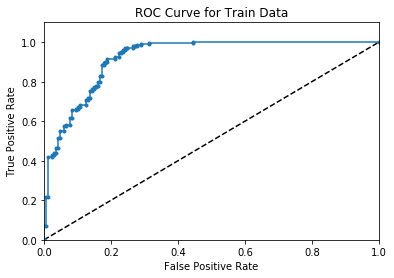

Confusion Matrix for Train Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |       284        |          1          |
+------------------+------------------+---------------------+
| Actual Malignant |        61        |         108         |
+------------------+------------------+---------------------+


In [27]:
print('TRAIN DATA EVALUATION')
print('---------------------------------------------')
print('Average Train Accuracy:', clusterAvgTrainAccuracy)
print('Average Train Precision:', clusterAvgTrainPrecision)
print('Average Train Recall:', clusterAvgTrainRecall)
print('Average Train F-Score:', clusterAvgTrainFScore)
print('Average Train AUC:', clusterAvgTrainAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(clusterTrainFPR, clusterTrainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Train Data:')
printConfusionMatrix(clusterTrainTN, clusterTrainFP, clusterTrainFN, clusterTrainTP)

# Unsupervised Learning Evaluation for Test Data.

In [28]:
for m in range(0, simulatedM):
    testMData = clusterTestMData[m]
    clusterTestDist = euclidean_distances(testMData[features], clusterMCentroids[m])
    clusterLabels = clusterMLabels[m]
    firstClusterLabel = clusterLabels[0]
    secondClusterLabel = clusterLabels[1]
    
    clusterTestTP = 0
    clusterTestTN = 0
    clusterTestFP = 0
    clusterTestFN = 0
    for i in range(0, len(clusterTestDist)):
        firstClusterDict = clusterTestDist[i][0]
        secondClusterDist = clusterTestDist[i][1]
        if firstClusterDict<secondClusterDist:
            if testMData['Class'][i]=='B':
                if firstClusterLabel=='B':
                    clusterTestTP += 1
                else:
                    clusterTestFN += 1
            else:
                if firstClusterLabel=='M':
                    clusterTestTN += 1
                else:
                    clusterTestFP += 1
        else:
            if testMData['Class'][i]=='B':
                if secondClusterLabel=='B':
                    clusterTestTP += 1
                else:
                    clusterTestFN += 1
            else:
                if secondClusterLabel=='M':
                    clusterTestTN += 1
                else:
                    clusterTestFP += 1
    
    clusterTestAccuracy = (clusterTestTP+clusterTestTN)/len(testMData)
    clusterTestAccuracy = round(clusterTestAccuracy, 3)
    
    clusterTestPrecision = clusterTestTP/(clusterTestTP+clusterTestFP)
    clusterTestPrecision = round(clusterTestPrecision, 3)
    
    clusterTestRecall = clusterTestTP/(clusterTestTP+clusterTestFN)
    clusterTestRecall = round(clusterTestRecall, 3)
    
    clusterTestFScore = (2*clusterTestPrecision*clusterTestRecall)/(clusterTestPrecision+clusterTestRecall)
    clusterTestFScore = round(clusterTestFScore, 3)
    
    clusterTestActualClass  = np.array(testMData['Class'])
    clusterTestPredProb = []
    for i in range(0, len(clusterTestDist)):
        firstClusterDict = clusterTestDist[i][0]
        secondClusterDist = clusterTestDist[i][1]
        if firstClusterLabel=='B':
            clusterTestPredProb.append(-1*firstClusterDict)
        else:
            clusterTestPredProb.append(-1*secondClusterDist)
    
    clusterTestFPR, clusterTestTPR, _ = roc_curve(clusterTestActualClass, clusterTestPredProb, pos_label='B')
    
    clusterTestAUC = auc(clusterTestFPR, clusterTestTPR)
    clusterTestAUC = round(clusterTestAUC, 3)
    
    clusterAvgTestAccuracy += clusterTestAccuracy
    clusterAvgTestPrecision += clusterTestPrecision
    clusterAvgTestRecall += clusterTestRecall
    clusterAvgTestFScore += clusterTestFScore
    clusterAvgTestAUC += clusterTestAUC
    
clusterAvgTestAccuracy /= simulatedM
clusterAvgTestAccuracy = round(clusterAvgTestAccuracy, 3)

clusterAvgTestPrecision /= simulatedM
clusterAvgTestPrecision = round(clusterAvgTestPrecision, 3)

clusterAvgTestRecall /= simulatedM
clusterAvgTestRecall = round(clusterAvgTestRecall, 3)

clusterAvgTestFScore /= simulatedM
clusterAvgTestFScore = round(clusterAvgTestFScore, 3)

clusterAvgTestAUC /= simulatedM
clusterAvgTestAUC = round(clusterAvgTestAUC, 3)

TEST DATA EVALUATION
---------------------------------------------
Average Test Accuracy: 0.855
Average Test Precision: 0.815
Average Test Recall: 0.997
Average Test F-Score: 0.896
Average Test AUC: 0.902


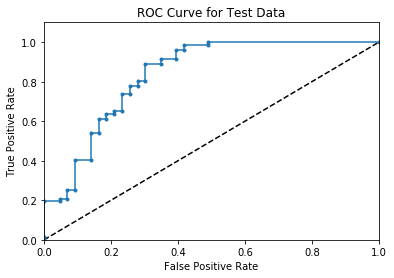

Confusion Matrix for Test Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |        72        |          0          |
+------------------+------------------+---------------------+
| Actual Malignant |        21        |         22          |
+------------------+------------------+---------------------+


In [29]:
print('TEST DATA EVALUATION')
print('---------------------------------------------')
print('Average Test Accuracy:', clusterAvgTestAccuracy)
print('Average Test Precision:', clusterAvgTestPrecision)
print('Average Test Recall:', clusterAvgTestRecall)
print('Average Test F-Score:', clusterAvgTestFScore)
print('Average Test AUC:', clusterAvgTestAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(clusterTestFPR, clusterTestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Test Data:')
printConfusionMatrix(clusterTestTN, clusterTestFP, clusterTestFN, clusterTestTP)

# Spectral Clustering

In spectral clustering, the data points are treated as nodes of a graph. The spectral clustering algorithm is treated as a graph partitioning problem. The data points/nodes are mapped to a low-dimensional space that can be easily segregated to form clusters. Points that are connected or are adjacent to each other are assigned to the same cluster. Also, no assumption is made about the shape of the clusters in this clustering algorithm. This clustering algorithm is reasonably fast for sparse datasets.

In [30]:
specClusterMCentroids = {}
specClusterTestMData = {}
specClusterMLabels = {}
specAvgTrainAccuracy = 0.0
specAvgTrainPrecision = 0.0
specAvgTrainRecall = 0.0
specAvgTrainFScore = 0.0
specAvgTrainAUC = 0.0
specAvgTestAccuracy = 0.0
specAvgTestPrecision = 0.0
specAvgTestRecall = 0.0
specAvgTestFScore = 0.0
specAvgTestAUC = 0.0

In [31]:
for m in range(0, simulatedM):
    trainMalignData, testMalignData = train_test_split(malignData, test_size=0.2, shuffle=True)
    trainBenignData, testBenignData = train_test_split(benignData, test_size=0.2, shuffle=True)
    
    trainMData = pd.concat([trainMalignData, trainBenignData])
    trainMData = trainMData.reset_index()
    testMData = pd.concat([testMalignData, testBenignData])
    testMData = testMData.reset_index()
    specClusterTestMData[m] = testMData
    
    spectralModel = SpectralClustering(n_clusters=2, gamma=1.0, eigen_tol=1.0, assign_labels='discretize')
    labels = spectralModel.fit_predict(trainMData[features])
    
    clusterCentroid = getClusterCentroids(labels, trainMData[features])
    specClusterMCentroids[m] = clusterCentroid
    
    specClusterTrainDist = euclidean_distances(trainMData[features], clusterCentroid)
    
    # Find count of class samples in each cluster
    firstMCnt = 0
    firstBCnt = 0
    secondMCnt = 0
    secondBCnt = 0
    for j in range(0, len(labels)):
        if labels[j]==0:
            if trainMData['Class'][j]=='M':
                firstMCnt += 1
            else:
                firstBCnt += 1
        else:
            if trainMData['Class'][j]=='M':
                secondMCnt += 1
            else:
                secondBCnt += 1
    
    # Assign cluster label
    firstLabel, secondLabel = getClusterLabel(firstMCnt, firstBCnt, secondMCnt, secondBCnt)        
    specClusterLabels = []
    specClusterLabels.append(firstLabel)
    specClusterLabels.append(secondLabel)
    specClusterMLabels[m] = specClusterLabels
        
    # Calculate TP, TN, FN and FP
    specTrainTP = 0
    specTrainTN = 0
    specTrainFP = 0
    specTrainFN = 0
    for i in range(0, len(trainMData)):
        actualLabel = trainMData['Class'][i]
        if labels[i]==0:
            if firstLabel=='B' and actualLabel=='B':
                specTrainTP += 1
            elif firstLabel=='B' and actualLabel=='M':
                specTrainFP += 1
            elif firstLabel=='M' and actualLabel=='B':
                specTrainFN += 1
            else:
                specTrainTN += 1
        else:
            if secondLabel=='B' and actualLabel=='B':
                specTrainTP += 1
            elif secondLabel=='B' and actualLabel=='M':
                specTrainFP += 1
            elif secondLabel=='M' and actualLabel=='B':
                specTrainFN += 1
            else:
                specTrainTN += 1
                
    specTrainAccuracy = (specTrainTP+specTrainTN)/len(trainMData)
    specTrainAccuracy = round(specTrainAccuracy, 3)
    
    specTrainPrecision = specTrainTP/(specTrainTP+specTrainFP)
    specTrainPrecision = round(specTrainPrecision, 3)
    
    specTrainRecall = specTrainTP/(specTrainTP+specTrainFN)
    specTrainRecall = round(specTrainRecall, 3)
    
    specTrainFScore = (2*specTrainPrecision*specTrainRecall)/(specTrainPrecision+specTrainRecall)
    specTrainFScore = round(specTrainFScore, 3)
    
    specTrainActualClass  = np.array(trainMData['Class'])
    specTrainPredProb = []
    for i in range(0, len(specClusterTrainDist)):
        firstClusterDist = specClusterTrainDist[i][0]
        secondClusterDist = specClusterTrainDist[i][1]
        if firstClusterLabel=='B':
            specTrainPredProb.append(-1*firstClusterDist)
        else:
            specTrainPredProb.append(-1*secondClusterDist)
    
    specTrainFPR, specTrainTPR, _ = roc_curve(specTrainActualClass, specTrainPredProb, pos_label='B')
    
    specTrainAUC = auc(specTrainFPR, specTrainTPR)
    specTrainAUC = round(specTrainAUC, 3)
    
    specAvgTrainAccuracy += specTrainAccuracy
    specAvgTrainPrecision += specTrainPrecision
    specAvgTrainRecall += specTrainRecall
    specAvgTrainFScore += specTrainFScore
    specAvgTrainAUC += specTrainAUC
    
specAvgTrainAccuracy /= simulatedM
specAvgTrainAccuracy = round(specAvgTrainAccuracy, 3)

specAvgTrainPrecision /= simulatedM
specAvgTrainPrecision = round(specAvgTrainPrecision, 3)

specAvgTrainRecall /= simulatedM
specAvgTrainRecall = round(specAvgTrainRecall, 3)

specAvgTrainFScore /= simulatedM
specAvgTrainFScore = round(specAvgTrainFScore, 3)

specAvgTrainAUC /= simulatedM
specAvgTrainAUC = round(specAvgTrainAUC, 3)

TRAIN DATA EVALUATION
---------------------------------------------
Average Train Accuracy: 0.597
Average Train Precision: 0.633
Average Train Recall: 0.861
Average Train F-Score: 0.715
Average Train AUC: 0.856


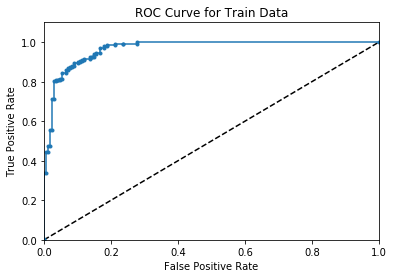

Confusion Matrix for Train Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |       285        |          0          |
+------------------+------------------+---------------------+
| Actual Malignant |       169        |          0          |
+------------------+------------------+---------------------+


In [32]:
print('TRAIN DATA EVALUATION')
print('---------------------------------------------')
print('Average Train Accuracy:', specAvgTrainAccuracy)
print('Average Train Precision:', specAvgTrainPrecision)
print('Average Train Recall:', specAvgTrainRecall)
print('Average Train F-Score:', specAvgTrainFScore)
print('Average Train AUC:', specAvgTrainAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(specTrainFPR, specTrainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Train Data:')
printConfusionMatrix(specTrainTN, specTrainFP, specTrainFN, specTrainTP)

In [33]:
for m in range(0, simulatedM):
    testMData = specClusterTestMData[m]
    specClusterTestDist = euclidean_distances(testMData[features], specClusterMCentroids[m])
    
    specClusterLabels = specClusterMLabels[m]
    specFirstLabel = specClusterLabels[0]
    specSecondLabel = specClusterLabels[1]
    
    specTestTP = 0
    specTestTN = 0
    specTestFP = 0
    specTestFN = 0
    for i in range(0, len(specClusterTestDist)):
        specFirstClusterDict = specClusterTestDist[i][0]
        specSecondClusterDist = specClusterTestDist[i][1]
        if specFirstClusterDict<specSecondClusterDist:
            if testMData['Class'][i]=='B':
                if specFirstLabel=='B':
                    specTestTP += 1
                else:
                    specTestFN += 1
            else:
                if specFirstLabel=='M':
                    specTestTN += 1
                else:
                    specTestFP += 1
        else:
            if testMData['Class'][i]=='B':
                if specSecondLabel=='B':
                    specTestTP += 1
                else:
                    specTestFN += 1
            else:
                if specSecondLabel=='M':
                    specTestTN += 1
                else:
                    specTestFP += 1
                
    specTestAccuracy = (specTestTP+specTestTN)/len(testMData)
    specTestAccuracy = round(specTestAccuracy, 3)
    
    specTestPrecision = specTestTP/(specTestTP+specTestFP)
    specTestPrecision = round(specTestPrecision, 3)
    
    specTestRecall = specTestTP/(specTestTP+specTestFN)
    specTestRecall = round(specTestRecall, 3)
    
    specTestFScore = (2*specTestPrecision*specTestRecall)/(specTestPrecision+specTestRecall)
    specTestFScore = round(specTestFScore, 3)
    
    specTestActualClass  = np.array(testMData['Class'])
    specTestPredProb = []
    for i in range(0, len(specClusterTestDist)):
        firstClusterDist = specClusterTestDist[i][0]
        secondClusterDist = specClusterTestDist[i][1]
        if firstClusterLabel=='B':
            specTestPredProb.append(-1*firstClusterDist)
        else:
            specTestPredProb.append(-1*secondClusterDist)
    
    specTestFPR, specTestTPR, _ = roc_curve(specTestActualClass, specTestPredProb, pos_label='B')
    
    specTestAUC = auc(specTestFPR, specTestTPR)
    specTestAUC = round(specTestAUC, 3)
    
    specAvgTestAccuracy += specTestAccuracy
    specAvgTestPrecision += specTestPrecision
    specAvgTestRecall += specTestRecall
    specAvgTestFScore += specTestFScore
    specAvgTestAUC += specTestAUC
    
specAvgTestAccuracy /= simulatedM
specAvgTestAccuracy = round(specAvgTestAccuracy, 3)

specAvgTestPrecision /= simulatedM
specAvgTestPrecision = round(specAvgTestPrecision, 3)

specAvgTestRecall /= simulatedM
specAvgTestRecall = round(specAvgTestRecall, 3)

specAvgTestFScore /= simulatedM
specAvgTestFScore = round(specAvgTestFScore, 3)

specAvgTestAUC /= simulatedM
specAvgTestAUC = round(specAvgTestAUC, 3)

TEST DATA EVALUATION
---------------------------------------------
Average Test Accuracy: 0.541
Average Test Precision: 0.592
Average Test Recall: 0.752
Average Test F-Score: 0.658
Average Test AUC: 0.85


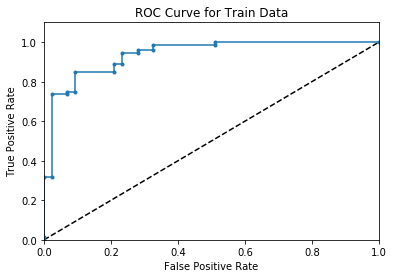

Confusion Matrix for Train Data:
+==================+==================+=====================+
|                  | Predicted Benign | Predicted Malignant |
+------------------+------------------+---------------------+
|  Actual Benign   |        59        |         13          |
+------------------+------------------+---------------------+
| Actual Malignant |        43        |          0          |
+------------------+------------------+---------------------+


In [34]:
print('TEST DATA EVALUATION')
print('---------------------------------------------')
print('Average Test Accuracy:', specAvgTestAccuracy)
print('Average Test Precision:', specAvgTestPrecision)
print('Average Test Recall:', specAvgTestRecall)
print('Average Test F-Score:', specAvgTestFScore)
print('Average Test AUC:', specAvgTestAUC)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(specTestFPR, specTestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('Confusion Matrix for Train Data:')
printConfusionMatrix(specTestTN, specTestFP, specTestFN, specTestTP)

# Compare the results.

In [35]:
tableData = []
row = []
row.append('Average Train Accuracy')
row.append(supAvgTrainAccuracy)
row.append(semiAvgTrainAccuracy)
row.append(clusterAvgTrainAccuracy)
tableData.append(row)

row = []
row.append('Average Test Accuracy')
row.append(supAvgTestAccuracy)
row.append(semiAvgTestAccuracy)
row.append(clusterAvgTestAccuracy)
tableData.append(row)

row = []
row.append('Average Train Precision')
row.append(supAvgTrainPrecision)
row.append(semiAvgTrainPrecision)
row.append(clusterAvgTrainPrecision)
tableData.append(row)

row = []
row.append('Average Test Precision')
row.append(supAvgTestPrecision)
row.append(semiAvgTestPrecision)
row.append(clusterAvgTestPrecision)
tableData.append(row)

row = []
row.append('Average Train Recall')
row.append(supAvgTrainRecall)
row.append(semiAvgTrainRecall)
row.append(clusterAvgTrainRecall)
tableData.append(row)

row = []
row.append('Average Test Recall')
row.append(supAvgTestRecall)
row.append(semiAvgTestRecall)
row.append(clusterAvgTestRecall)
tableData.append(row)

row = []
row.append('Average Train F-Score')
row.append(supAvgTrainFScore)
row.append(semiAvgTrainFScore)
row.append(clusterAvgTrainFScore)
tableData.append(row)

row = []
row.append('Average Test F-Score')
row.append(supAvgTestFScore)
row.append(semiAvgTestFScore)
row.append(clusterAvgTestFScore)
tableData.append(row)

row = []
row.append('Average Train AUC')
row.append(supAvgTrainAUC)
row.append(semiAvgTrainAUC)
row.append(clusterAvgTrainAUC)
tableData.append(row)

row = []
row.append('Average Test AUC')
row.append(supAvgTestAUC)
row.append(semiAvgTestAUC)
row.append(clusterAvgTestAUC)
tableData.append(row)

tableHeaders = ['', 'Supervised Learning', 'Semi-Supervised Learning', 'Unsupervised Learning']
printDatainTable(tableHeaders, tableData)

+=========================+=====================+==========================+=======================+
|                         | Supervised Learning | Semi-Supervised Learning | Unsupervised Learning |
+=========================+=====================+==========================+=======================+
| Average Train Accuracy  |        0.987        |          0.977           |         0.852         |
+-------------------------+---------------------+--------------------------+-----------------------+
|  Average Test Accuracy  |        0.965        |          0.958           |         0.855         |
+-------------------------+---------------------+--------------------------+-----------------------+
| Average Train Precision |        0.986        |          0.977           |         0.811         |
+-------------------------+---------------------+--------------------------+-----------------------+
| Average Test Precision  |        0.969        |          0.964           |         0.815 

## Conclusion:
It can be concluded that supervised learning on full dataset is working better as compared to semi-supervised learning with half of the labeled dataset. Also, unsupervised learning is underperforming on this dataset.